利用线性回归技术实现共享单车数量预测

一、数据说明： Capital Bikeshare （美国Washington, D.C.的一个共享单车公司）提供的共享单车数据。数据包含每天的日期、天气等信息，需要预测每天的共享单车骑行量。

原始数据集地址：http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset
1)	文件说明
day.csv: 按天计的单车共享次数（作业只需使用该文件）
hour.csv: 按小时计的单车共享次数（无需理会）
readme：数据说明文件

2)	字段说明
Instant记录号
Dteday：日期
Season：季节（1=春天、2=夏天、3=秋天、4=冬天）
yr：年份，(0: 2011, 1:2012)
mnth：月份( 1 to 12)
hr：小时 (0 to 23)  （只在hour.csv有，作业忽略此字段）
holiday：是否是节假日（0/1）
weekday：星期中的哪天，取值为0～6
workingday：是否工作日（0/1）
1=工作日 （是否为工作日，1为工作日，0为非周末或节假日）
weathersit：天气（1：晴天，多云 2：雾天，阴天 3：小雪，小雨 4：大雨，大雪，大雾）
temp：气温摄氏度
atemp：体感温度
hum：湿度
windspeed：风速
### 这两项可以做特征工程的时候去掉，只关注cnt就可以了
casual：非注册用户贡献的骑行量（作业无需理会该字段）
registered：注册用户贡献的骑行量（作业无需理会该字段）
cnt：给定日期（天, day.csv）时间（每小时,hour.csv）总租车人数，响应变量y

casual、registered和cnt三个特征均为要预测的y（cnt =casual+registered ），作业里只需对cnt进行预测。
# 特征工程

In [4]:
#导入必要的包
import sys
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [5]:
# 格式数据
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (30, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

sn.set_style('whitegrid')
sn.set_context('talk')

plt.rcParams.update(params)
pd.options.display.max_colwidth = 600

In [6]:
#读入数据
train = pd.read_csv("day.csv")
train.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [8]:
train.shape

(731, 16)

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
instant       731 non-null int64
dteday        731 non-null object
season        731 non-null int64
yr            731 non-null int64
mnth          731 non-null int64
holiday       731 non-null int64
weekday       731 non-null int64
workingday    731 non-null int64
weathersit    731 non-null int64
temp          731 non-null float64
atemp         731 non-null float64
hum           731 non-null float64
windspeed     731 non-null float64
casual        731 non-null int64
registered    731 non-null int64
cnt           731 non-null int64
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


In [10]:
#对数值型变量，可以使用describe查看其分布
train.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,366.000000,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,211.165812,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,183.500000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,366.000000,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,548.500000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,731.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


In [11]:
#离散型特征分布
#对类别性特征，观察其取值返回及直方图
categorical_features = ['season', 'mnth', 'weathersit', 'weekday']
for col in categorical_features:
    print("{0}属性不同取值和出现次数".format(col))
    print(train[col].value_counts())
    #将类别性特征转化为object
    train[col] = train[col].astype('object')

season属性不同取值和出现次数
3    188
2    184
1    181
4    178
Name: season, dtype: int64
mnth属性不同取值和出现次数
12    62
10    62
8     62
7     62
5     62
3     62
1     62
11    60
9     60
6     60
4     60
2     57
Name: mnth, dtype: int64
weathersit属性不同取值和出现次数
1    463
2    247
3     21
Name: weathersit, dtype: int64
weekday属性不同取值和出现次数
6    105
1    105
0    105
5    104
4    104
3    104
2    104
Name: weekday, dtype: int64


In [12]:
#已经讲类别型特征转化为object类型
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
instant       731 non-null int64
dteday        731 non-null object
season        731 non-null object
yr            731 non-null int64
mnth          731 non-null object
holiday       731 non-null int64
weekday       731 non-null object
workingday    731 non-null int64
weathersit    731 non-null object
temp          731 non-null float64
atemp         731 non-null float64
hum           731 non-null float64
windspeed     731 non-null float64
casual        731 non-null int64
registered    731 non-null int64
cnt           731 non-null int64
dtypes: float64(4), int64(7), object(5)
memory usage: 91.5+ KB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f066d32f0f0>,
      dtype=object)

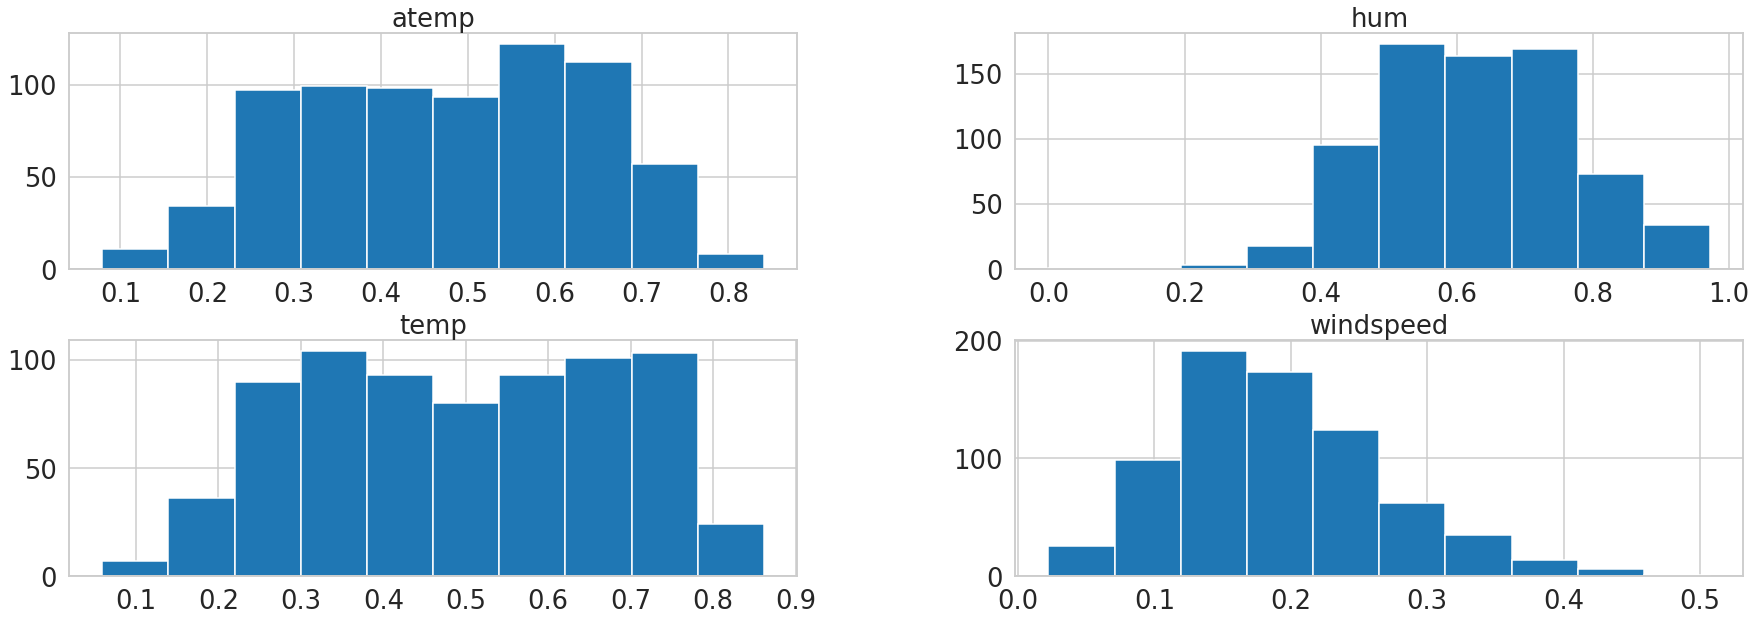

In [13]:
# 数值型特征分布
numerical_features = ['temp', 'atemp', 'hum', 'windspeed']
train[numerical_features].hist()

In [ ]:
#特征与特征之间的关系
#violinplot中用x表示类别(年)信息

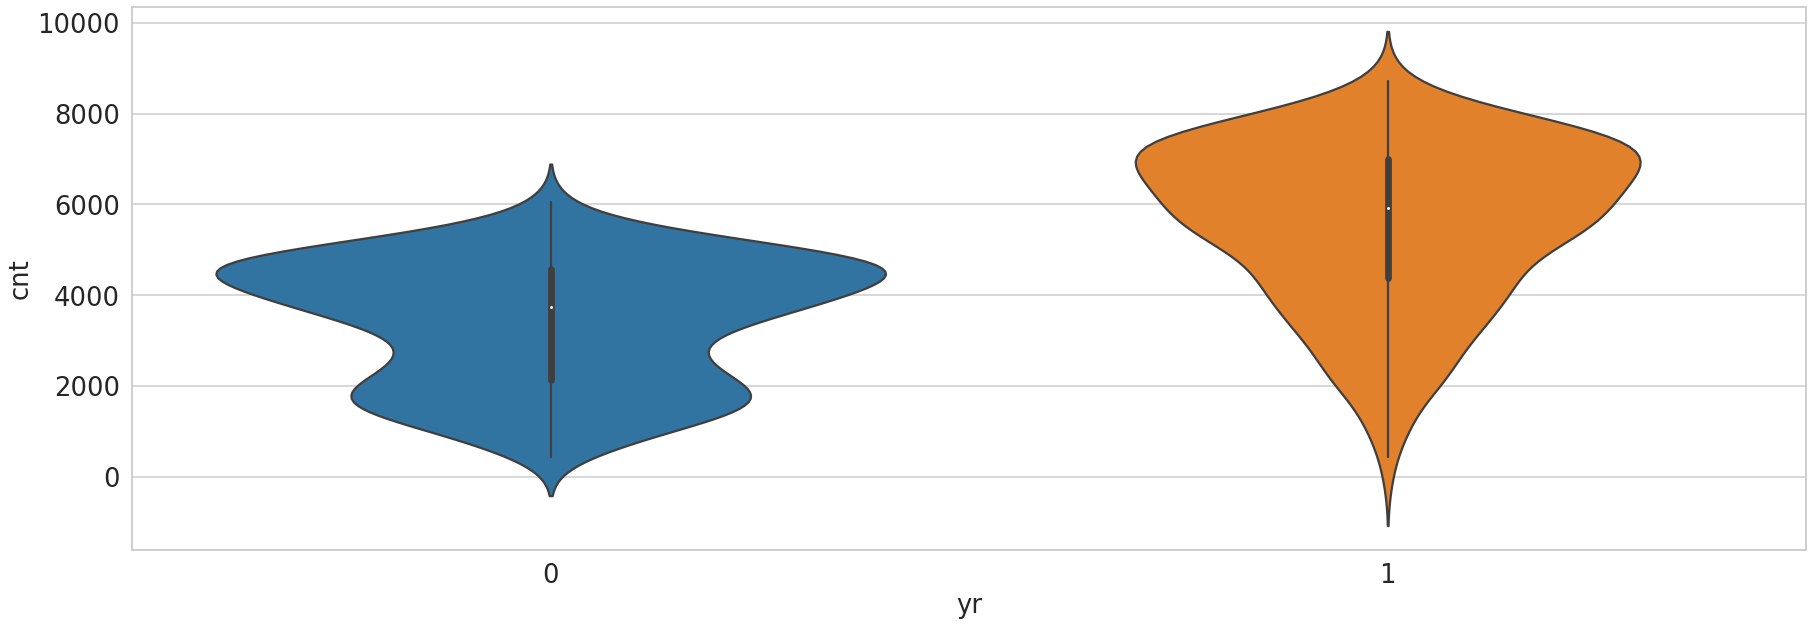

In [14]:
sn.violinplot(data = train[['yr', 'cnt']], x = 'yr', y = 'cnt')

[Text(0.5, 1.0, 'dayly distribution of counts')]

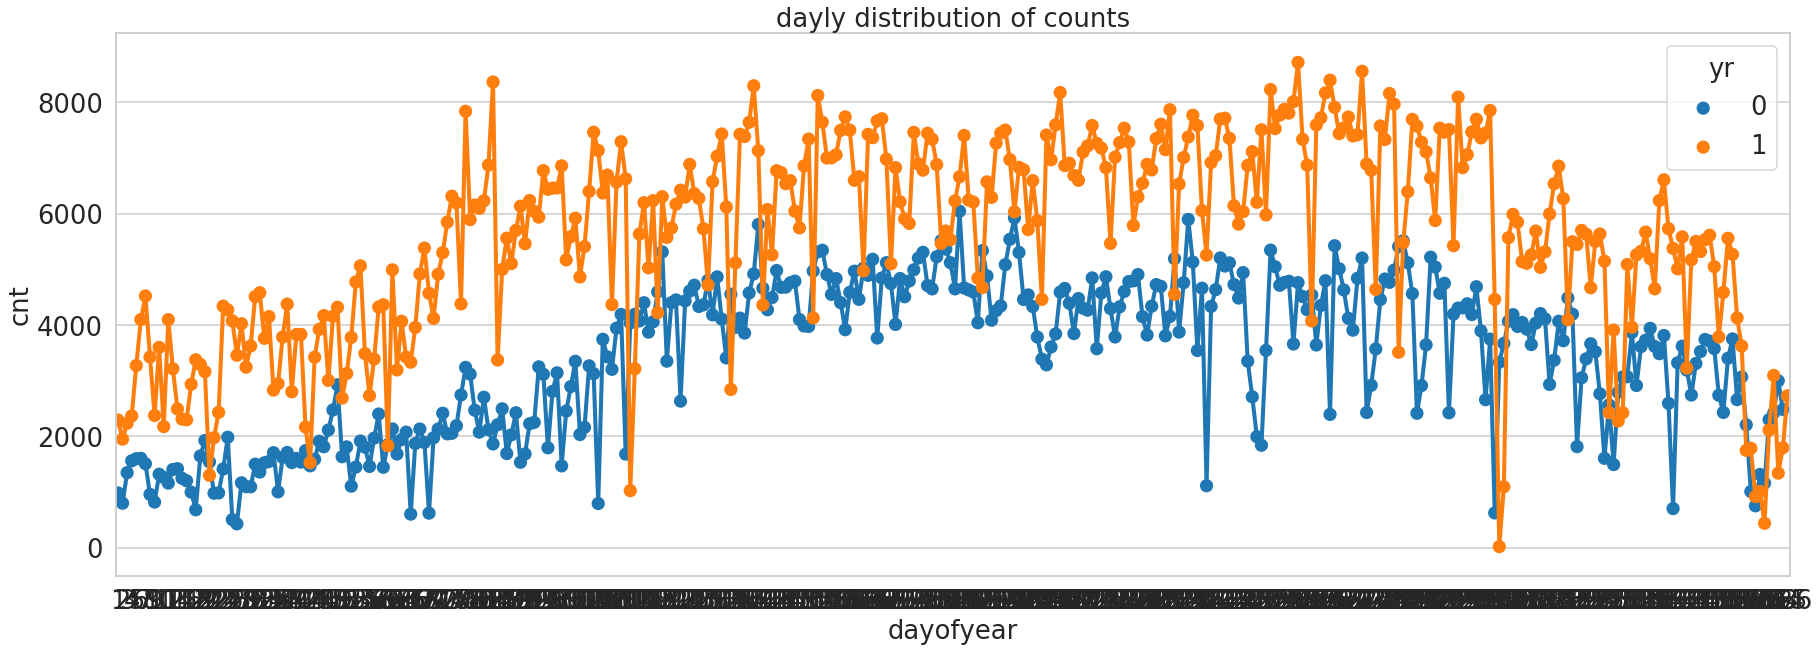

In [15]:
#一年中的每天的骑行量
#用颜色参数hue表示类别（年）信息
import datetime
train['date'] = pd.to_datetime(train['dteday'])
#今年的第几天
train['dayofyear'] = train['date'].dt.dayofyear

fig, ax = plt.subplots()
sn.pointplot(data = train[['dayofyear', 'cnt', 'yr']], x = 'dayofyear', y = 'cnt', hue='yr', ax = ax)
ax.set(title = "dayly distribution of counts")

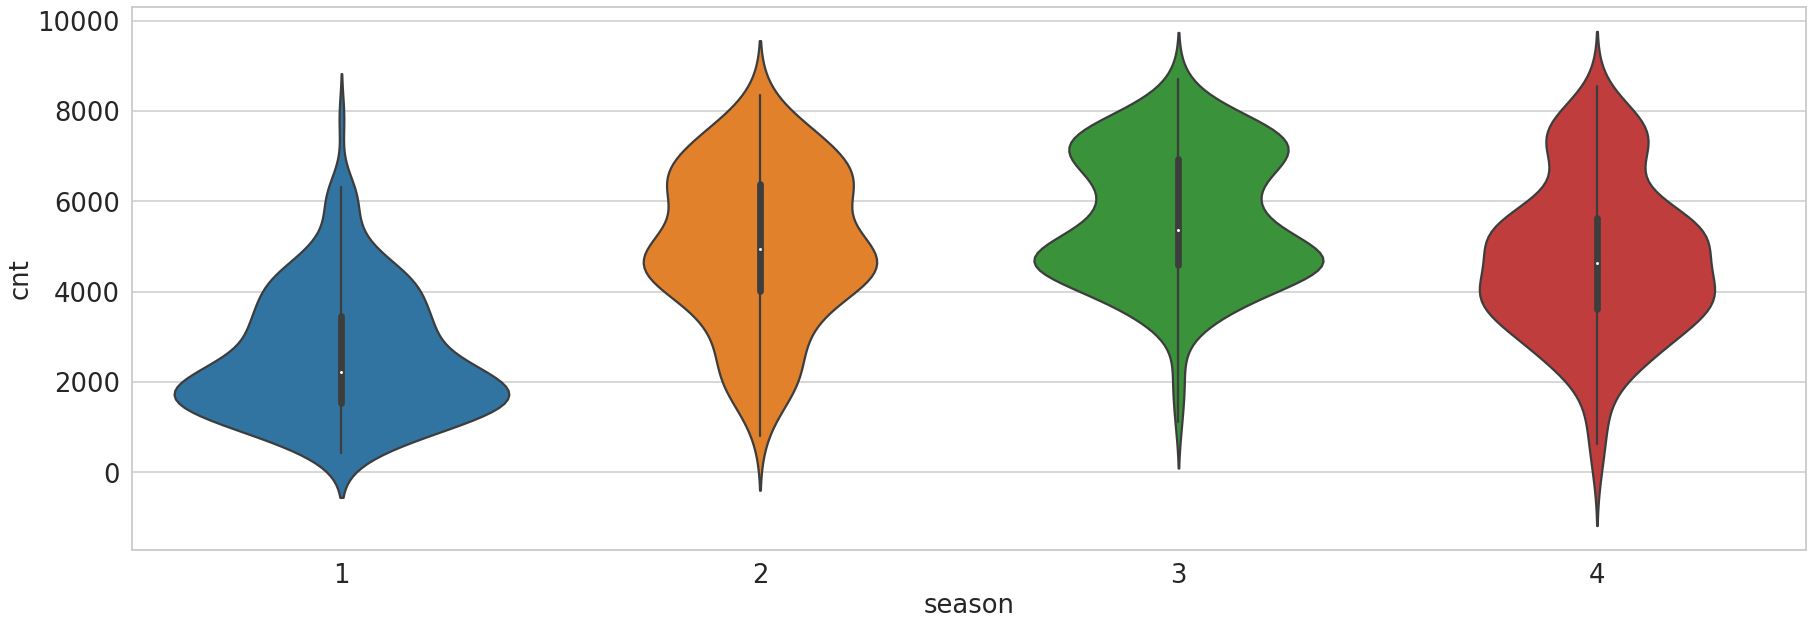

In [16]:
#季节与骑行量的关系
sn.violinplot(data = train[['season','cnt']], x='season', y ='cnt')

[Text(0.5, 1.0, 'Seasonly distribution of counts')]

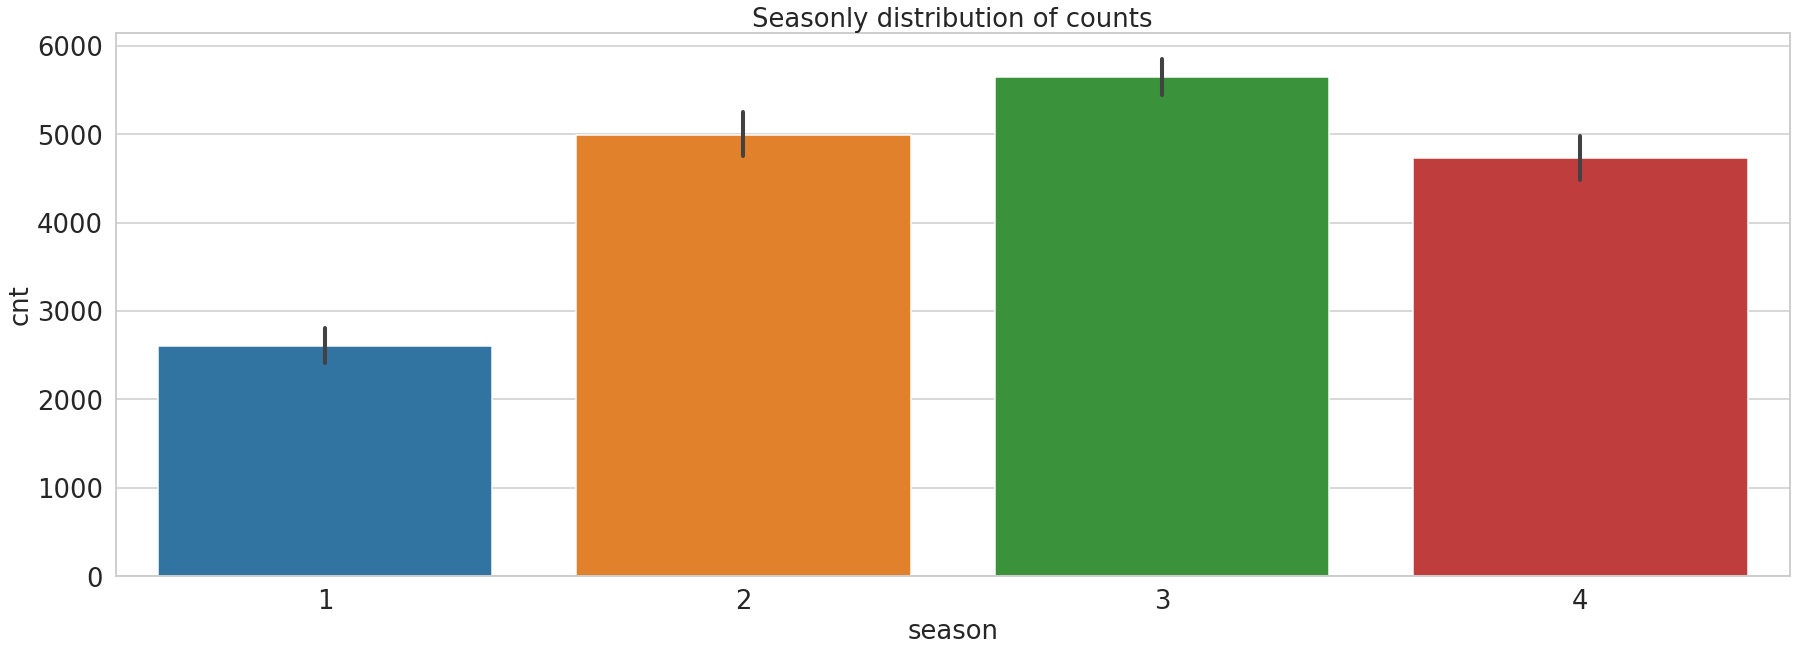

In [17]:
#barplot 利用矩阵条的高度反应数值变量的集中趋势，以及使用errorbar功能(差棒图)来估计变量之间的差值统计
#谨记barplot展示的是某种变量分布的平均值
fig, ax = plt.subplots()
sn.barplot(data = train[['season','cnt']], x='season', y ='cnt')
ax.set(title = "Seasonly distribution of counts")

[Text(0.5, 1.0, 'monthly distribution of counts')]

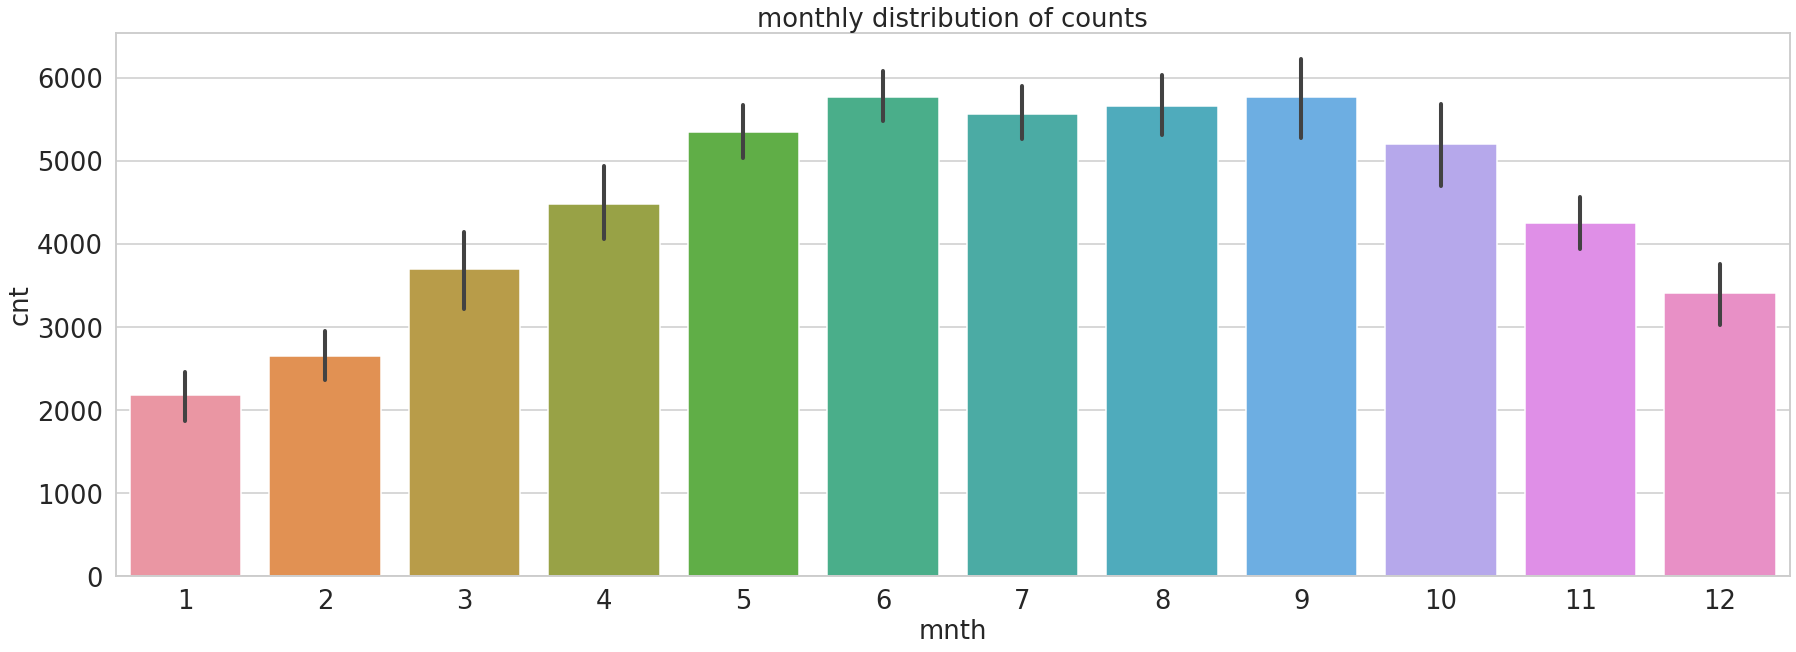

In [18]:
#月份与骑行量的关系
fig, ax = plt.subplots()
sn.barplot(data = train[['mnth', 'cnt']], x='mnth', y = 'cnt')
ax.set(title = "monthly distribution of counts")

[Text(0.5, 1.0, 'weathersit distribution of counts')]

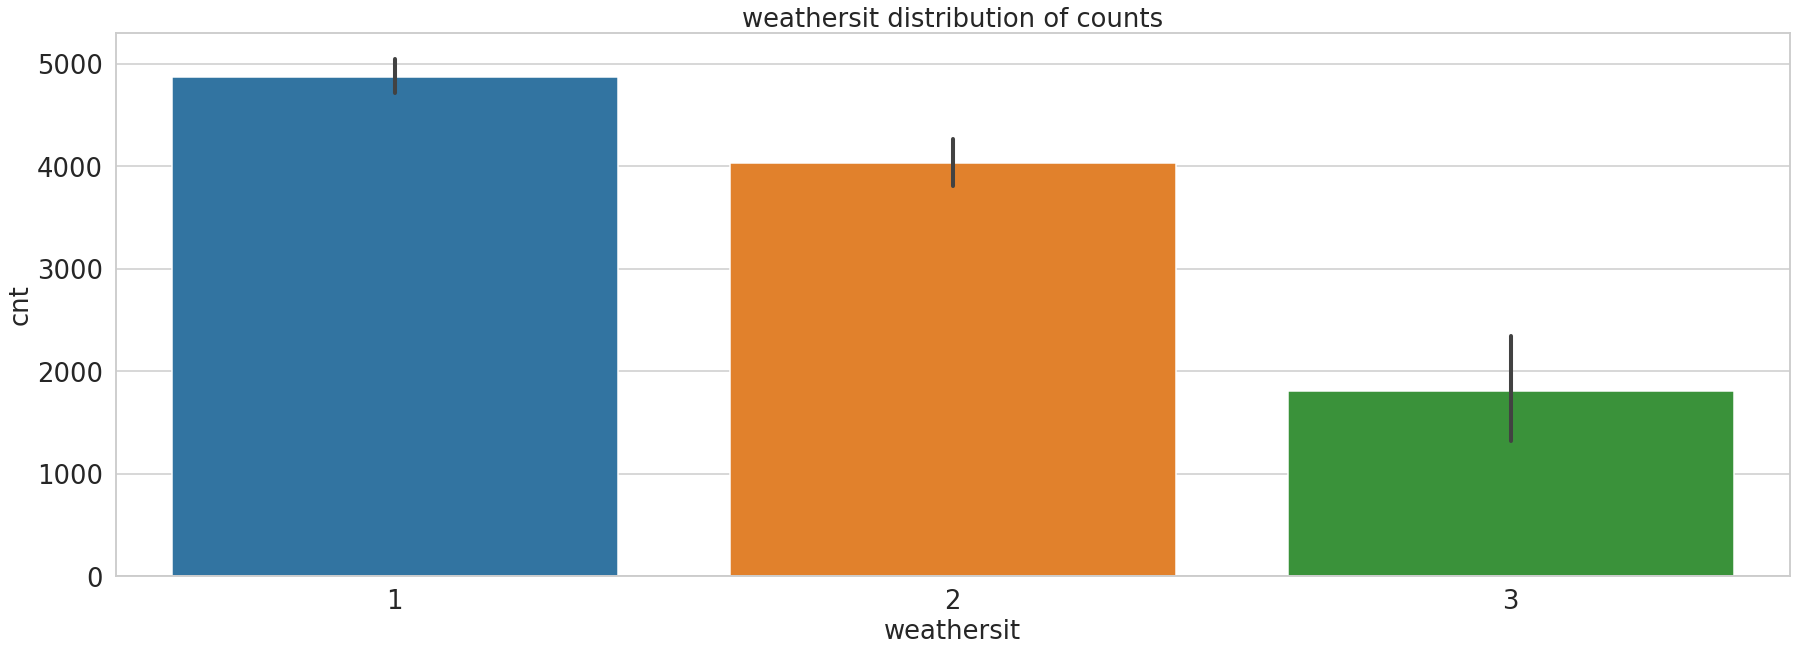

In [19]:
#天气与骑行量的关系
fig, ax = plt.subplots()
sn.barplot(data = train[['weathersit', 'cnt']], x='weathersit', y = 'cnt')
ax.set(title = "weathersit distribution of counts")

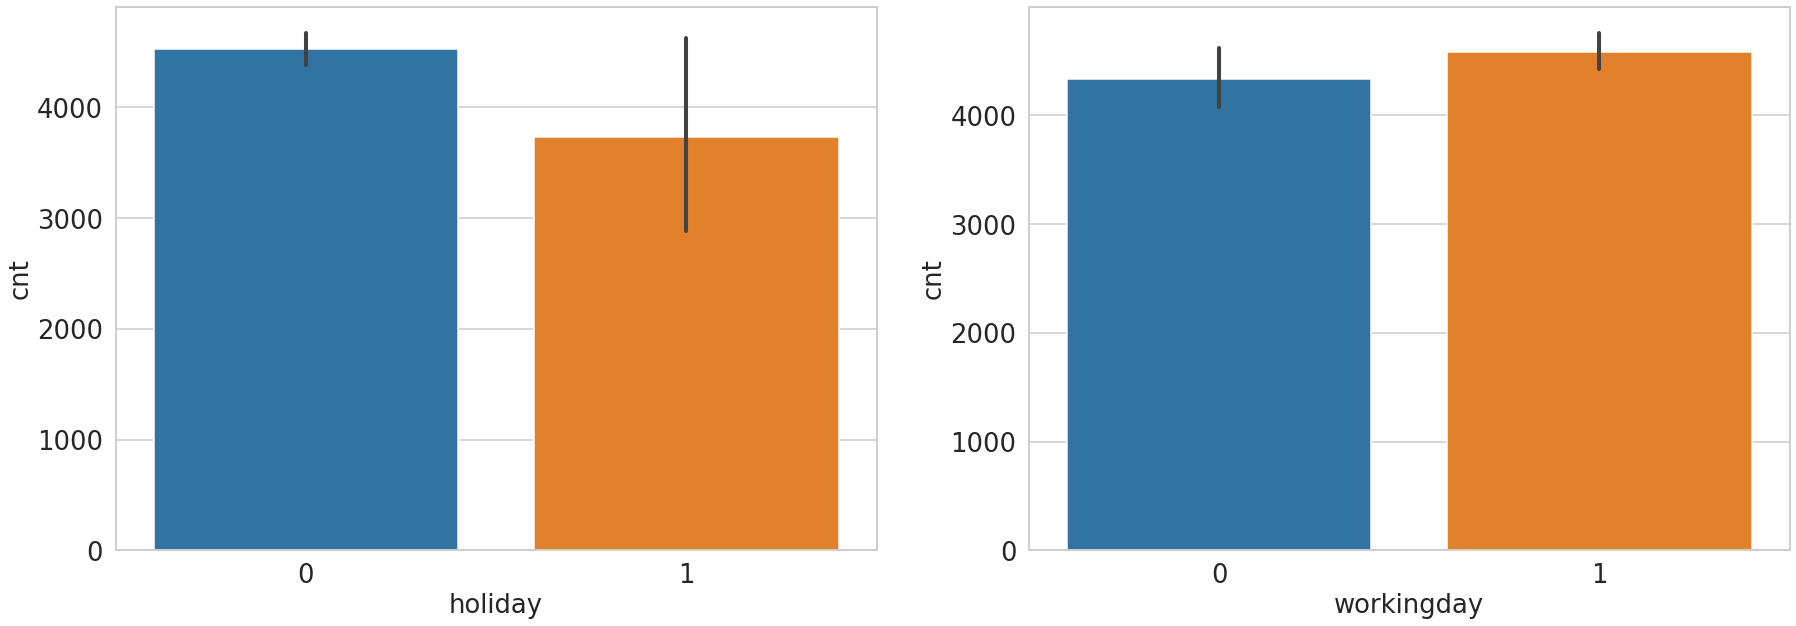

In [20]:
#工作日与节假日的分布
fig, (ax1, ax2) = plt.subplots(ncols = 2)
sn.barplot(data = train, x = 'holiday', y = 'cnt', ax = ax1)
sn.barplot(data = train, x = 'workingday', y = 'cnt', ax = ax2)

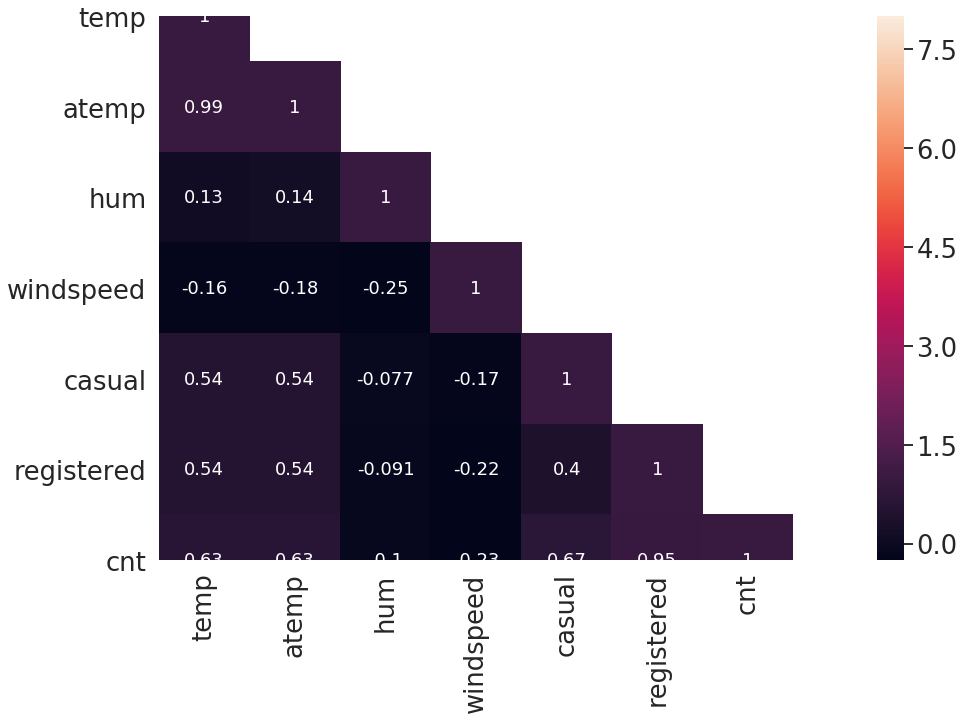

In [21]:
#数值型特征与y之间的相关性
corrMatt = train[['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']].corr()

mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
sn.heatmap(corrMatt, mask = mask, vmax = 8, square = True, annot = True)

In [23]:
#类别性变量特征编码
#对类别性变量进行独热编码
#前面部分已经对离散型特征进行了转换为object的操作，这里就不用了
'''
categorical_features = ['season', 'mnth', 'weathersit', 'weekday']
for col in categorical_features:
    print("{0}属性不同取值和出现次数".format(col))
    print(train[col].value_counts())
    #将类别性特征转化为object
    train[col] = train[col].astype('object')
'''
X_train_cat = train[categorical_features]
#独热编码
X_train_cat = pd.get_dummies(X_train_cat)
X_train_cat.head()

,season_1,season_2,season_3,season_4,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,...,weathersit_1,weathersit_2,weathersit_3,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,1,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,1,0,0,0,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
2,1,0,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
3,1,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
4,1,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


In [24]:
#数值型特征
#对数值型特征进行标准化/MinMaxScaler,去量纲
#数值型变量预处理
#感觉数据已经做过处理，取值都在0-1之间，这里用MinMaxScaler再处理一次
from sklearn.preprocessing import MinMaxScaler
mn_x = MinMaxScaler()
numerical_features = ['temp', 'atemp', 'hum', 'windspeed']
temp = mn_x.fit_transform(train[numerical_features])

X_train_num = pd.DataFrame(data = temp, columns = numerical_features, index = train.index)
X_train_num.head()

,temp,atemp,hum,windspeed
0,0.355170,0.373517,0.828620,0.284606
1,0.379232,0.360541,0.715771,0.466215
2,0.171000,0.144830,0.449638,0.465740
3,0.175530,0.174649,0.607131,0.284297
4,0.209120,0.197158,0.449313,0.339143


In [25]:
#将数值型特征和类别性特征合并到一起
X_train = pd.concat([X_train_cat, X_train_num, train['holiday'], train['workingday']], axis = 1, ignore_index = False)
X_train.head()

,season_1,season_2,season_3,season_4,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,...,weekday_3,weekday_4,weekday_5,weekday_6,temp,atemp,hum,windspeed,holiday,workingday
0,1,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0.355170,0.373517,0.828620,0.284606,0,0
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0.379232,0.360541,0.715771,0.466215,0,0
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0.171000,0.144830,0.449638,0.465740,0,1
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0.175530,0.174649,0.607131,0.284297,0,1
4,1,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0.209120,0.197158,0.449313,0.339143,0,1


In [27]:
FE_train = pd.concat([train['instant'], X_train, train['yr'], train['cnt']], axis = 1)
FE_train.to_csv('FE_BikeSharing.csv', index = False)
FE_train.head()

,instant,season_1,season_2,season_3,season_4,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,...,weekday_5,weekday_6,temp,atemp,hum,windspeed,holiday,workingday,yr,cnt
0,1,1,0,0,0,1,0,0,0,0,...,0,1,0.355170,0.373517,0.828620,0.284606,0,0,0,985
1,2,1,0,0,0,1,0,0,0,0,...,0,0,0.379232,0.360541,0.715771,0.466215,0,0,0,801
2,3,1,0,0,0,1,0,0,0,0,...,0,0,0.171000,0.144830,0.449638,0.465740,0,1,0,1349
3,4,1,0,0,0,1,0,0,0,0,...,0,0,0.175530,0.174649,0.607131,0.284297,0,1,0,1562
4,5,1,0,0,0,1,0,0,0,0,...,0,0,0.209120,0.197158,0.449313,0.339143,0,1,0,1600


In [28]:
FE_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 35 columns):
instant         731 non-null int64
season_1        731 non-null uint8
season_2        731 non-null uint8
season_3        731 non-null uint8
season_4        731 non-null uint8
mnth_1          731 non-null uint8
mnth_2          731 non-null uint8
mnth_3          731 non-null uint8
mnth_4          731 non-null uint8
mnth_5          731 non-null uint8
mnth_6          731 non-null uint8
mnth_7          731 non-null uint8
mnth_8          731 non-null uint8
mnth_9          731 non-null uint8
mnth_10         731 non-null uint8
mnth_11         731 non-null uint8
mnth_12         731 non-null uint8
weathersit_1    731 non-null uint8
weathersit_2    731 non-null uint8
weathersit_3    731 non-null uint8
weekday_0       731 non-null uint8
weekday_1       731 non-null uint8
weekday_2       731 non-null uint8
weekday_3       731 non-null uint8
weekday_4       731 non-null uint8
weekday_5       731 